# Learning the moments of a loss using neural networks

In this tutorial we show how to use the algorithm of Chassot et al. (**TITLE**) to learn optimal moments using neural networks. 

In [51]:
from models.simple_models import *
from black_it.loss_functions.moment_networks.tcn import *
from black_it.loss_functions.moment_networks.moment_network import MomentNetwork
from black_it.search_space import SearchSpace
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.xgboost import XGBoostSampler
from black_it.loss_functions.msm import MethodOfMomentsLoss
from black_it.calibrator import Calibrator

import matplotlib.pyplot as plt
import numpy as np
import torch

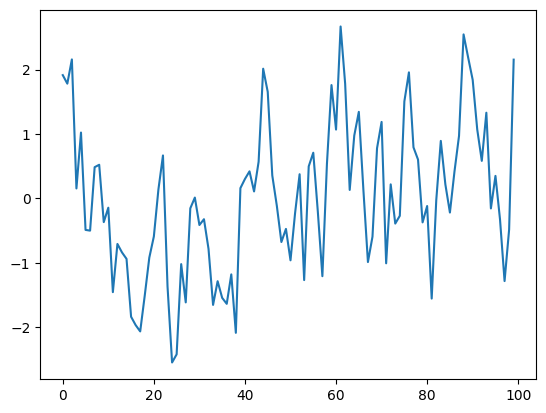

In [52]:
# We focus on learning a moment for the AR1 model
plt.plot(AR1([0.7], 100, None))

### Learning a function to find the optimal "moments" of a time series

In [53]:
# Define a search space for the parameter
parameters_bounds = [[-1 + 1e-3],[1 - 1e-3]]
parameters_precision = [0.001]

search_space = SearchSpace(parameters_bounds = parameters_bounds,
            parameters_precision = parameters_precision,
            verbose = False)

# Define a sampler for the network. 
# Note that batch_size corresponds also to the size of the minibatches used for training
network_sampler =  HaltonSampler(batch_size=256)


In [54]:
# Create a simple moment network to learn a single moment

mnet = MomentNetwork(
    net = TemporalConvNet(1, 1, [10, 10, 10], 32),
    model = AR1,
    search_space = search_space,
    sampler = network_sampler,
    N = 100, 
    verbosity = 10,
)

/Users/aldoglielmo/miniconda3/envs/momnet/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [55]:
# Train the network for a number of epochs
mnet.train_network()

Epoch  10 - Running loss: 0.3318
Epoch  20 - Running loss: 0.2944
Epoch  30 - Running loss: 0.1588
Epoch  40 - Running loss: 0.0679
Epoch  50 - Running loss: 0.0399
Epoch  60 - Running loss: 0.0291
Epoch  70 - Running loss: 0.0239
Epoch  80 - Running loss: 0.0215
Epoch  90 - Running loss: 0.0195
Epoch 100 - Running loss: 0.0188


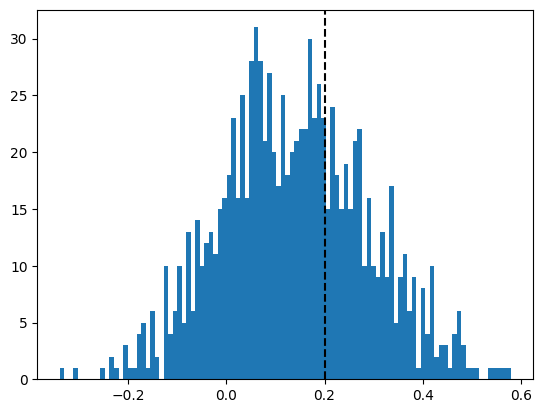

In [57]:
# Set the network to evaluation mode and generate some data at an arbitrary theta
mnet.eval()
theta = [0.2]


X = np.hstack([AR1(theta, mnet.N, None) for _ in range(1000)])
X = torch.tensor(X, dtype=mnet.batch_dtype).transpose(1, 0).unsqueeze(1)

# evaluate data in a vectorised way using the internal pytorch model
Y = mnet.net(X).detach().numpy()

# Plot the results of the network's point estimates
# Check that the learned network is indeed very similar to the original parameter
plt.hist(Y, bins=100)
plt.axvline(theta[0], color = 'k', ls = '--')
plt.show()

### Use the learned moment function within a method of moments search

In [58]:
# use the moment network as a moment calculator
moment_calculator = mnet

# define a method of moments loss with a specific moment calculator
loss = MethodOfMomentsLoss(moment_calculator = moment_calculator)

# use any search method
search_method = XGBoostSampler(batch_size = 64)

# define a synthetic target time series
target_series = AR1([0.2], 100, 0)


In [59]:
cal = Calibrator(loss_function=loss, 
                 real_data=target_series, 
                 parameters_bounds=parameters_bounds, 
                 parameters_precision=parameters_precision,
                 model=AR1, 
                 ensemble_size=5, 
                 samplers=[search_method])


***
Number of free params:       1.
Explorable param space size: 1999.
***

Selecting 8 processes for the parallel evaluation of the model


In [60]:
params, losses = cal.calibrate(5)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: XGBoostSampler
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:1517: Empty dataset at worker: 0
[15:46:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38

----> sim exec elapsed time: 1.1s
---->   min loss new params: 0.0
---->   avg loss new params: 0.38
----> avg loss exist params: 0.38
---->         curr min loss: 0.00010398851009085774
====>    total elapsed time: 1.1s

BATCH NUMBER:   2
PARAMS SAMPLED: 64

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.3s
---->   min loss new params: 0.0
---->   avg loss new params: 0.06
----> avg loss exist params: 0.22
---->         curr min loss: 0.00010398851009085774
====>    total elapsed time: 0.4s

BATCH NUMBER:   3
PARAMS SAMPLED: 128

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.3s
---->   min loss new params: 0.0
---->   avg loss new params: 0.05
----> avg loss exist params: 0.16
---->         curr min loss: 8.097860586531169e-07
====>    total elapsed time: 0.4s

BATCH NUMBER:   4
PARAMS SAMPLED: 192

METHOD: XGBoostSampler
----> sim exec elapsed time: 0.3s
---->   min loss new params: 0.0
---->   avg loss new params: 0.06
----> avg loss exist params: 0.14
---->         c

In [61]:
params[0:3]

array([[0.136],
       [0.191],
       [0.265]])

In [48]:
Y.mean()

0.6542314

In [50]:
Y.std()*2 

0.19000853598117828